# 1) Постановка задачи
Используя метод переменных направлений, решить начально-краевую задачу для уравнения теплопроводности в прямоугольнике:
$$
\left\{\begin{aligned}
& \frac{\partial u}{\partial t} = 4\Delta u,~0<x<10,~0<y<5,~0<t<T \\
& u\rvert{_{x=0}} = u\rvert{_{x=10}} = 0 \\
& \left.\frac{\partial u}{\partial y}\right\rvert_{y=0} = \left.\frac{\partial u}{\partial y}\right\rvert_{y=5} = 0 \\
& u\rvert{_{t=0}} = \sin{\pi x}\cos{2\pi y}
\end{aligned}\\
\right. 
$$

Эта задача имеет аналитическое решение:
$$ u(x,y,t) = \sin{\pi x}\cos{2\pi y}\exp{(-20\pi^2 t)} $$

Импортируем необходимые библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Введем равномерную сетку в расчетной области

In [2]:
Nx, Ny, Nt = 100, 100, 100
X1, X2 = 0, 10
Y1, Y2 = 0, 5
T1, T2 = 0, 0.01

h_x=(X2-X1)/Nx
h_y=(Y2-Y1)/(Ny-1)
tau=(T2-T1)/Nt

x = np.linspace(X1,X2,Nx+1)
y = np.linspace(Y1-h_y/2,Y2+h_y/2,Ny+1)
t = np.linspace(T1,T2,Nt+1)

gamma_1 = 4 * tau / (h_x*h_x)
gamma_2 = 4 * tau / (h_y*h_y)

w = np.zeros((Nx + 1, Ny + 1, 2*(Nt + 1) - 1))

# 2) Аналитическое решение

In [3]:
u = np.zeros((Nx+1,Ny+1,Nt+1))
for n in range(0,Nx+1):              
    for m in range(0,Ny+1):
        for j in range(0,Nt+1):
            u[n,m,j]=np.sin(np.pi*x[n]) * np.cos(2*np.pi*y[m]) * np.exp(-20*(np.pi ** 2)*t[j])

# 3) Реализация численного решения

## Зададим начальные условия:

In [4]:
for n in range(0, Nx+1):
    for m in range(0, Ny+1):
        w[n,m,0] = np.sin(np.pi*x[n]) * np.cos(2*np.pi*y[m])

## Прогонка по х:

In [5]:
def progonX(m,j):
    
    alpha = np.zeros(Nx+1)             
    beta = np.zeros(Nx+1)
    
    alpha[0] = 0           
    beta[0] = 0       #на левой границе по x ставится однородное условие Дирихле
    
    A = 0.5 * gamma_1
    B = 0.5 * gamma_1
    C = 1 + gamma_1
    
    #прямой ход прогонки
    for n in range (1, Nx):
        F_n = 0.5 * gamma_2 * (w[n,m-1,j] + w[n,m+1,j]) + (1-gamma_2) * w[n,m,j]
        alpha[n] = B / (C - A * alpha[n-1])  
        beta[n] = (F_n + A * beta[n-1]) / (C - A * alpha[n-1])
    
    alpha[Nx] = 0   #на правой границе по x ставится однородное условие Дирихле
    beta[Nx] = 0  
    
    #обратный ход
    w[Nx,m,j] = beta[Nx]
    for n in range(Nx-1, -1, -1):                  
        w[n,m,j] = alpha[n] * w[n+1,m,j] + beta[n]

## Прогонка по у:

In [6]:
def progonY(n,j):
    
    alpha = np.zeros(Ny+1)
    beta = np.zeros(Ny+1)
    
    alpha[0] = 1            #на левой границе по y ставится однородное условие Неймана
    beta[0] = 0        
    
    A = 0.5 * gamma_2
    B = 0.5 * gamma_2
    C = 1 + gamma_2
    
    #прямой ход прогонки
    for m in range (1,Ny):
        F_m = 0.5 * gamma_1 * (w[n+1,m,j-1] + w[n-1,m,j-1]) + (1 - gamma_1) * w[n,m,j-1]
        alpha[m] = B / (C - A * alpha[m-1])  
        beta[m] = (F_m + A * beta[m-1]) / (C - A * alpha[m-1])
    
    alpha[Ny] = 0
    beta[Ny] = beta[Ny-1]/(1 - alpha[Ny-1])      #на правой границе по y ставится однородное условие Неймана
    
    
    #обратный ход прогонки
    w[n,Ny,j] = beta[Ny]
    for m in range(Ny-1, -1, -1):                  
        w[n,m,j] = alpha[m] * w[n,m+1,j] + beta[m]

## Численное решение:

In [7]:
for j in tqdm(range(0, 2*(Nt + 1) - 2)):
    for m in range(0,Ny):
        progonX(m,j)
    for n in range(0,Nx):
        progonY(n,j+1)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:41<00:00,  4.76it/s]


# 4) Графики

## Аналитическое решение в динамике

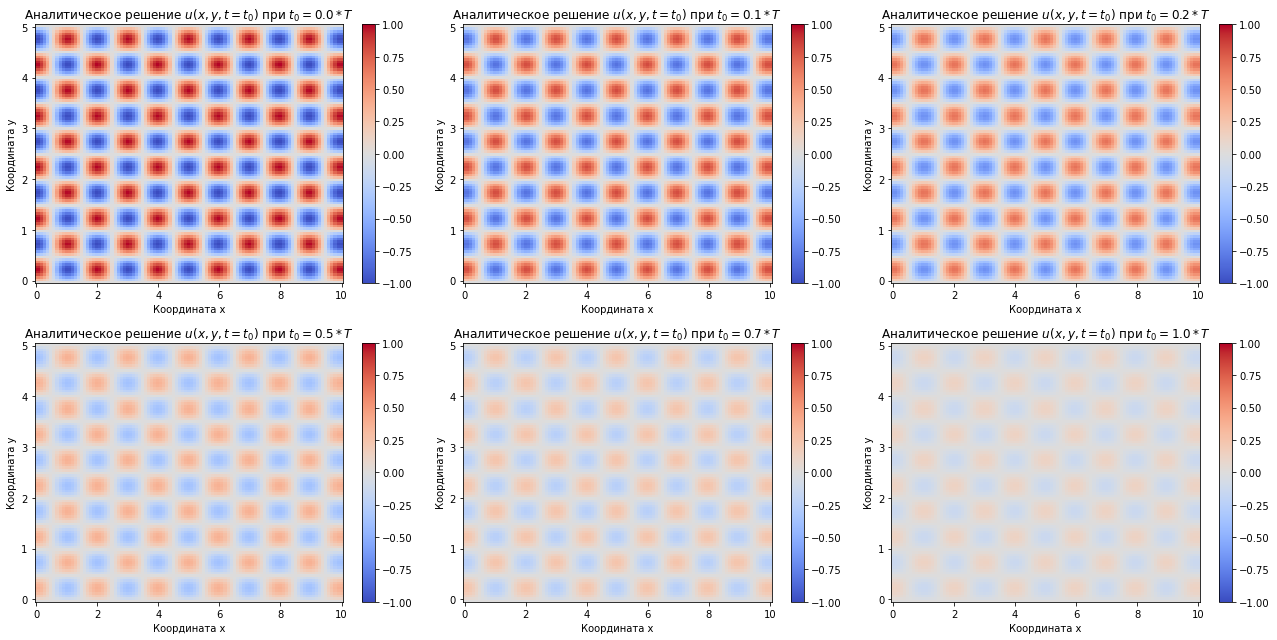

In [8]:
%matplotlib inline
t0 = [0, 10, 20, 50, 70, 100]
fig, axes = plt.subplots(2, 3, figsize = (18,9))
for i in range(len(t0)):
    plt.subplot(2, 3, i+1)
    plt.pcolormesh(x, y, u[:,:,t0[i]], cmap = 'coolwarm', shading = 'auto', vmin = -1, vmax = 1)
    plt.colorbar()
    plt.xlabel('Координата x')
    plt.ylabel('Координата y')
    plt.title('Аналитическое решение $u(x,y,t=t_0)$ при $t_0 = {0}*T$'.format(t0[i]/100))
plt.tight_layout()

## Численное решение в динамике

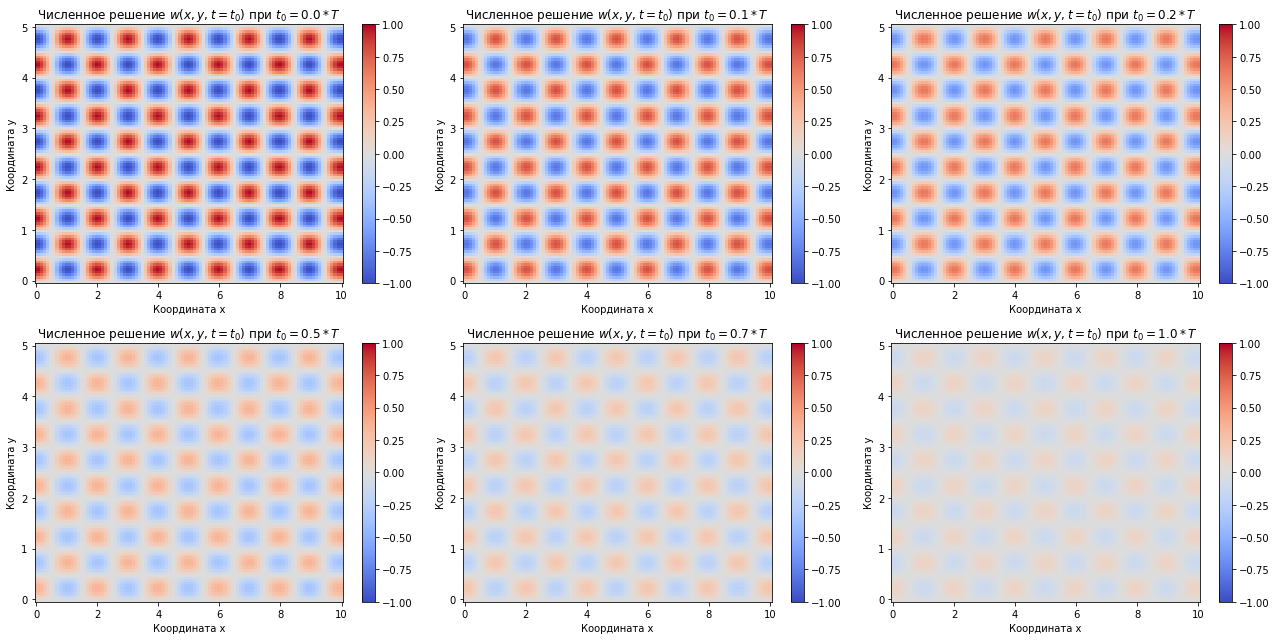

In [9]:
%matplotlib inline
t0 = [0, 10, 20, 50, 70, 100]
fig, axes = plt.subplots(2, 3, figsize = (18,9))
for i in range(len(t0)):
    plt.subplot(2, 3, i+1)
    plt.pcolormesh(x, y, w[:,:,t0[i]], cmap = 'coolwarm', shading = 'auto', vmin = -1, vmax = 1)
    plt.colorbar()
    plt.xlabel('Координата x')
    plt.ylabel('Координата y')
    plt.title('Численное решение $w(x,y,t=t_0)$ при $t_0 = {0}*T$'.format(t0[i]/100))
plt.tight_layout()

## Невязка в динамике

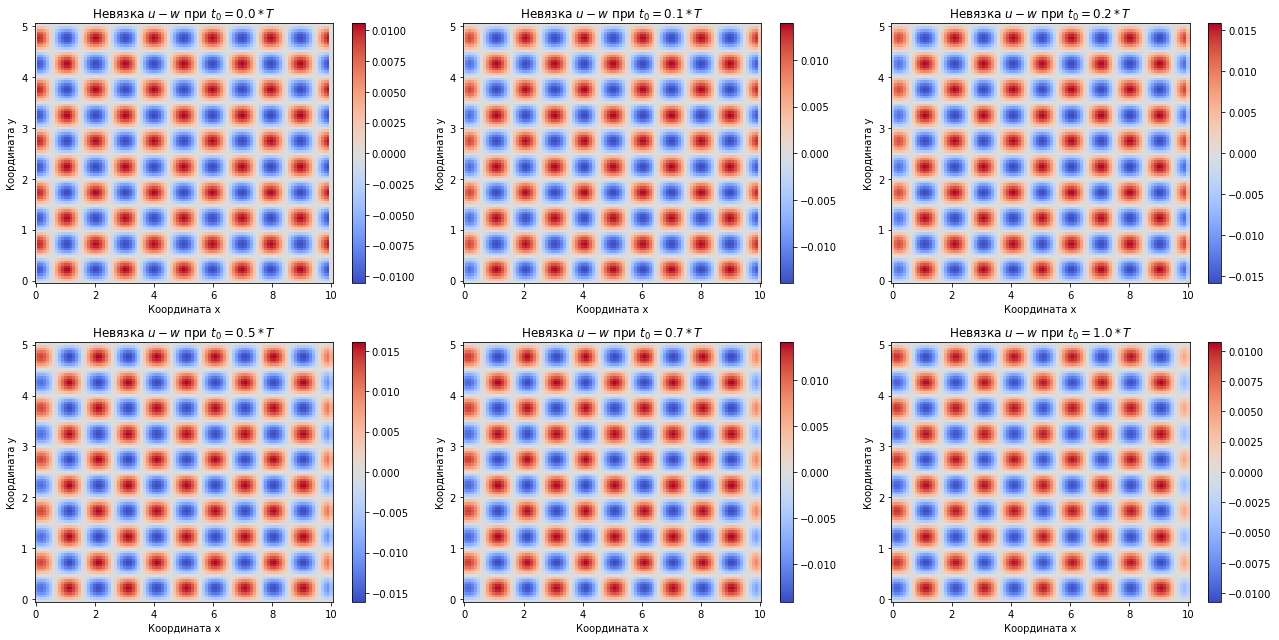

In [10]:
%matplotlib inline
t0 = [0, 10, 20, 50, 70, 100] 
fig, axes = plt.subplots(2, 3, figsize = (18,9))
for i in range(len(t0)):
    plt.subplot(2, 3, i+1)
    plt.pcolormesh(x, y, w[:,:,t0[i]] - u[:,:,t0[i]], cmap = 'coolwarm', shading = 'auto')
    plt.colorbar()
    plt.xlabel('Координата x')
    plt.ylabel('Координата y')
    plt.title('Невязка $u-w$ при $t_0 = {0}*T$'.format(t0[i]/100))
plt.tight_layout()

## Профили решений при фиксированном y в различные моменты времени

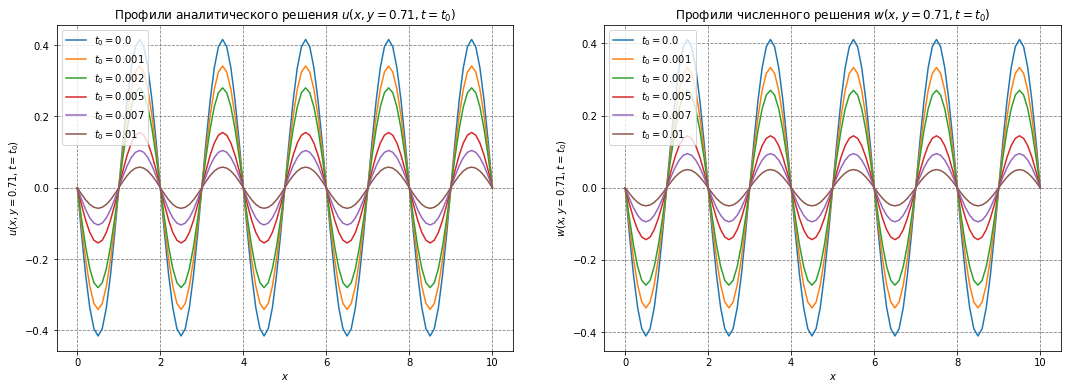

In [16]:
%matplotlib inline
y_const = 14
t0 = [0, 10, 20, 50, 70, 100]
fig, axes = plt.subplots(1, 2, figsize = (18, 6))

plt.subplot(1, 2, 1)
for i in range(len(t0)):
    plt.plot(x, u[:,y_const,t0[i]], label = '$t_0 = {0}$'.format(t0[i]*tau))
plt.title('Профили аналитического решения $u(x, y={0},t=t_0)$'.format(np.round(y_const*h_y, 2)))
plt.xlabel('$x$')
plt.ylabel('$u(x, y={0},t=t_0)$'.format(np.round(y_const*h_y, 2)))
plt.legend()
plt.grid(which='major', color = 'gray',ls='--')

plt.subplot(1, 2, 2)
for i in range(len(t0)):
    plt.plot(x, w[:,y_const,t0[i]], label = '$t_0 = {0}$'.format(t0[i]*tau))
plt.title('Профили численного решения $w(x, y={0},t=t_0)$'.format(np.round(y_const*h_y, 2)))
plt.xlabel('$x$')
plt.ylabel('$w(x, y={0},t=t_0)$'.format(np.round(y_const*h_y, 2)))
plt.legend()
plt.grid(which='major', color = 'gray',ls='--')

## Численное решение при t = const

<IPython.core.display.Javascript object>


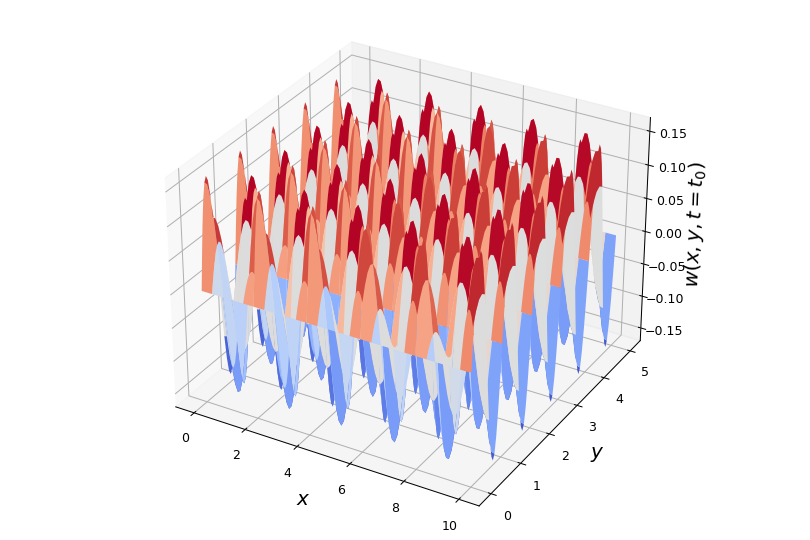

In [12]:
t_0 = 90

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

fig = plt.figure(figsize = (9,6))
axes = Axes3D(fig)

x1,y1 = np.meshgrid(x,y)

axes.plot_surface(x1, y1, w[:,:,t_0], rstride=4, cstride=4, cmap = cm.coolwarm)

plt.xlabel('$x$', size=16)
plt.ylabel('$y$', size=16)
axes.set_zlabel('$w(x,y,t=t_0)$', size = 16)
plt.title('$w(x,y,t=t_0)$ в момент $t_0 = {0}*T$'.format(t_0/100))
plt.show()